# Expanding on Ito et al. (2017) to recover simulated task activity and connectivity matrix


Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm

Import custom modules

In [2]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [3]:
phi = lambda x: np.tanh(x)

inv_phi = lambda x: np.arctanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

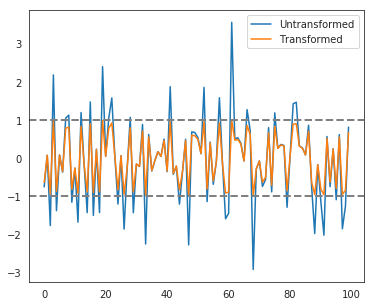

In [4]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

In Ito et al. (2017) $\tau_i$, $s$, $g$ and $dt$ are set to 1. This simplifies the equation to:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

***Create structural and synaptic network***

One hub and two local networks

In [5]:
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

In [6]:
# Construct structural matrix
S = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
W = model.generateSynapticNetwork(S, showplot=False)

Text(0.5, 1.0, 'Synaptic Weight Matrix -- Coupling Matrix')

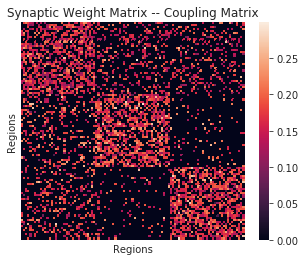

In [7]:
plt.rcParams["figure.figsize"][0] = 5
plt.rcParams["figure.figsize"][1] = 4
sns.heatmap(W, xticklabels=False, yticklabels=False)
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.title("Synaptic Weight Matrix -- Coupling Matrix")

Note in this matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

In [8]:
## Set up simulation parameters
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0

### Task activity 

***Hub network stimulation***

In [9]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
Tmax = 100000 

T = np.arange(0,Tmax,dt)
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

Block design where stimulus is ON for 500 ms every 2 seconds looks like:

(-0.1, 1.2)

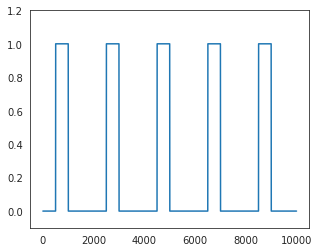

In [10]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

In [11]:
stimtimes = {}

topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/3.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

# When task is ON the activity for a stim_node at that time point is .5
for t in range(len(T)):
    if tasktiming[0,t] == 1:
        stimtimes[task][stim_nodes,t] = .5

Activated nodes in the hub network *only* (making it a top-down task) are:

In [12]:
stim_nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

`taskdata` is an $n$ by $t$ matrix containing the timeseries for each node where $n$-rows are for nodes and $t$ columns are for the time points.

It is generated by updating each column (each time point) for **all nodes**  

At each time point the differential equation describing the change in activity is solved using the [Runge-Kutta second order method](https://lpsa.swarthmore.edu/NumInt/NumIntSecond.html).

\begin{equation*}
\frac{dx_i}{dt} = \frac{-x_i(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + s\phi\big(x_i(t)\big) + I_i(t)}{\tau_i}
\end{equation*}

Thus `taskdata` for all nodes $x_i$ current activity plus a weighted sum of change in activity as predicted by the solutions of the differential equation.

\begin{equation*}
x_{i}(t+dt) = x_{i}(t) + \frac{k1_{i}+k2_{i}}{2}
\end{equation*}

where the derivative based on $t(0)$ that will be used for the approximation is

\begin{equation*}
k1_{i} = \frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}
\end{equation*}

$\hat{I}_{i}(t)$ is the spontaneous activity that is the sum of randomly generated noise and task-related stimulation ($\hat{I}_{i}(t) = {I}_{i}(t)+\epsilon(t)$). Since the column-vector of task-related stimulation activity is very sparse ($|I_{i}(t)| \neq 0$ only for $i$ that is the third of the hub nodes and only for a short window of timepoints $t$) **most of the activity feeds into updating the activity of a node is noise (which in this framework is the equivalent of rest activity)**.

Using this slope the first intermediate approximation at the endpoint is

\begin{equation*}
x_{i}^*(t+dt) = x_{i}(t) + k1_{i} dt
\end{equation*}

and the second order approximation for the change in activity is

\begin{equation*}
k2_{i} = \frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}
\end{equation*}

If we discretize and work through the algebra the row-wise 'expanded' GLM for the column-wise generated data using the Runge-Kutte method would be:

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{k1_{i}+k2_{i}}{2}
\end{equation*}

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}^*(t+dt) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}^*(t+dt)\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

Replacing $x_{i}^*(t+dt)$

\begin{equation*}
x_{i}(t+1) = x_{i}(t) + dt\frac{\frac{-x_{i}(t) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + s\phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)}{\tau}+\frac{-x_{i}(t) - k1_{i} dt + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + s\phi\big(x_{i}(t) + k1_{i} dt\big) + \hat{I}_{i}(t+1)}{\tau}}{2}
\end{equation*}

Getting ride of $s, g, \tau, dt$ (as they are 1 in these simulations) cleaning up and moving the denominator

\begin{equation*}
2x_{i}(t+1) = \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - k1_{i} + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\big(x_{i}(t) + k1_{i} \big) + \hat{I}_{i}(t+1)
\end{equation*}

Replacing $k1_i$

\begin{equation*}
2x_{i}(t+1) = \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) - \Bigg[-x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg] + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\big(x_{i}(t) + \Bigg[-x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg]\big) + \hat{I}_{i}(t+1)
\end{equation*}

Cleanup

\begin{equation*}
2x_{i}(t+1) = x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\Bigg(\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg) + \hat{I}_{i}(t+1)
\end{equation*}

We can use this equation to expand the traditinal GLM. A traditional GLM would have modeled

\begin{equation*}
x_{i}(t) = h(t) \circledast I(t) + \epsilon_i(t)
\end{equation*}

that is the activity of a voxel at a given time point would have been a function of the convolved task activity for that node at that time point plus some noise (For these simulations we ignore other movement confounds etc. included in level 1 models in real data).  

With the expanded model derived from the approximation of the differential equation we model the value at the next time step of a given node ($x_{i}(t+1)$) as a function of their activity in the current time step ($x_{i}(t)$), the transformed activity in the next time step from all other nodes weighted by their connection weights to the given node ($\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg)$), the transformed activity in the current time step resulting from other nodes, self and task ($\phi\Bigg(\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t)\Bigg)$) and task activity for that node in the next time step ($\hat{I}_{i}(t+1)$).

In [13]:
out = model.networkModel(W,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)
taskdata = out[0]
noise = out[1]
#taskdata = model.networkModel(W,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
#                                          I=stimtimes[task], noise=1)

## Extending GLM to recover true task activity and connectivity matrix

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. I don't think this is the same thing as 'subtracting out' resting state to look at the remaining task activity.


### Correcting task activity while estimating the connectivity matrix

With real data we can estimate the weight matrix from resting state but we wouldn't know which nodes a task activates. Thus we wouldn't have access to $\hat{I}_i(t)$ but only to $\hat{I}(t)$, i.e. assume that the regressor has the same effect on all nodes. 

Since we can measure the timeseries for all nodes and know the task structure we could run this model to back out the weight matrix $W_{ij}$. But the row of incoming connection weights that we are trying to estimate using the whole time series of a given voxel appears in both the second *and* the third term of this model. Moreover as it goes through a non-linear transformation in the third term we cannot simplify the equation futher.  

Considered applying the inverse of the transformation function $\phi$

\begin{equation*}
\phi^{-1}(2x_{i}(t+1)) = \phi^{-1}(x_{i}(t)) + \phi^{-1}\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(x_{i}(t)\big) + \hat{I}_{i}(t) + \phi^{-1}(\hat{I}_{i}(t+1))
\end{equation*}

but the values that the inverse transform is applied to are >1 so it didn't work. Instead distributed the $\phi$ even though it does not have the distributive property.

\begin{equation*}
2x_{i}(t+1) = x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(\phi\big(x_{i}(t)\big)\big) + \phi(\hat{I}_{i}(t)) + \hat{I}_{i}(t+1)
\end{equation*}

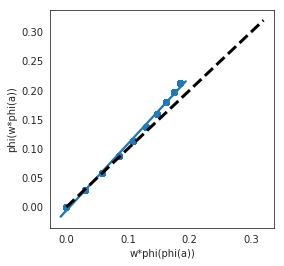

In [22]:
plt.rcParams["figure.figsize"][0] = 4
plt.rcParams["figure.figsize"][1] = 4

#Anticipated problems
df = pd.DataFrame(data = {'a':np.repeat(np.arange(0,1,.1), 10), 'b': np.tile(np.arange(0,1,.1), 10)})
df['w'] = 0.3
df['w*phi(phi(a))'] = df['w']*phi(phi(df['a']))
df['phi(w*phi(a))'] = phi(df['w']*phi(df['a']))

sns.regplot(x = 'w*phi(phi(a))', y = 'phi(w*phi(a))', data = df)
plt.plot((0, .32), (0, .32), 'k--', linewidth=3)

The problem doesn't look very drastic in the graph above so we distribute the transformation and run this model:

\begin{equation*}
2x_{i}(t+1) = x_{i}(t) + \Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t+1)\big)\Bigg) + \phi\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(\hat{I}_j(t)\big)\Bigg) + \phi\big(\phi\big(x_{i}(t)\big)\big) + \phi(\hat{I}_{i}(t)) + \hat{I}_{i}(t+1)
\end{equation*}

we are interested in three questions:  

- Is the estimate for the coefficient of task-related activity closer to its true value of 0.5 for stimulated nodes ($\hat{I}_{i}(t+1)$)?
- Is the estimate for the coeffient of current nodes' activity ($x_{i}(t)$) 1?
- Is the matrix consisting of coefficients of ($\phi\big(\hat{I}_j(t)\big)$) similar to the synaptic weight matrix? (row-wise populated for each node denoting the incoming connectivity strength from other nodes to given node)

In [24]:
#Using first third of the data for speed of estimation
taskdata_short = copy.copy(taskdata[:,:15000])

In [25]:
#x = copy.copy(stimtimes[task][0,:15000].T)
y = copy.copy(taskdata_short)
I = copy.copy(stimtimes[task][:,:15000])

In [26]:
ntimepoints = y.shape[1]
nregions = y.shape[0]

#Initialize empty variables
ucr_task = np.zeros((nregions))
ext_cur_node = np.zeros((nregions)) 
ext_weight_matrix = np.zeros((nregions, nregions-1))
ext_phi_weight_matrix = np.zeros((nregions, nregions-1))
ext_phi_phi_cur_node = np.zeros((nregions))
ext_phi_task = np.zeros((nregions))
ext_task = np.zeros((nregions))


In [27]:
for region in range(0, nregions):
    
    cur_y = y[region,:]
    #task_reg = I[region,:]
    task_reg = I[0,:]

    ucr_mod = sm.OLS(cur_y, task_reg)
    ucr_res = ucr_mod.fit()
    ucr_task[region] = ucr_res.params[0]

    #Extended model 
    next_y = 2*cur_y[1:] #shift column up to predict next multiplied activity

    cur_y = cur_y[:-1] #drop last time point

    drop_region = [region]
    other_ns_next_spont = np.delete(y, drop_region, axis=0)[:,1:] #dropping first col/timepoint
    other_ns_next_spont = other_ns_next_spont.T
    other_ns_next_spont = np.apply_along_axis(phi, 0, other_ns_next_spont)

    other_ns_cur_spont = np.delete(y, drop_region, axis=0)[:,:-1] #dropping last col/timepoint
    other_ns_cur_spont = other_ns_cur_spont.T
    other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)
    other_ns_cur_spont = np.apply_along_axis(phi, 0, other_ns_cur_spont)

    cur_y_phi_phi = phi(phi(cur_y))

    #cur_n_cur_spont_phi = phi(I[region,:-1])
    cur_n_cur_spont_phi = phi(task_reg[:-1])
    
    #cur_n_next_spont = I[region,1:]
    cur_n_next_spont = task_reg[1:]

    ext_des_mat = np.concatenate((cur_y.reshape(-1,1), other_ns_next_spont), 1)
    ext_des_mat = np.concatenate((ext_des_mat, other_ns_cur_spont), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_y_phi_phi.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_cur_spont_phi.reshape(-1,1)), 1)
    ext_des_mat = np.concatenate((ext_des_mat, cur_n_next_spont.reshape(-1,1)), 1)

    ext_mod = sm.OLS(next_y, ext_des_mat)
    ext_res = ext_mod.fit()
    ext_params = ext_res.params

    ext_cur_node[region] = ext_params[0]
    ext_weight_matrix[region,:] = ext_params[1:nregions]
    ext_phi_weight_matrix[region,:] = ext_params[nregions:2*nregions-1]
    ext_phi_phi_cur_node[region] = ext_params[-3]
    ext_phi_task[region] = ext_params[-2]
    ext_task[region] = ext_params[-1]

#### Task betas reduced after correction?

Yes, but not the level of 'true' activity (0.5) for all activated nodes.


In [28]:
task_betas = pd.DataFrame(data = {'ucr_task': ucr_task,
                         'ext_task': ext_task})

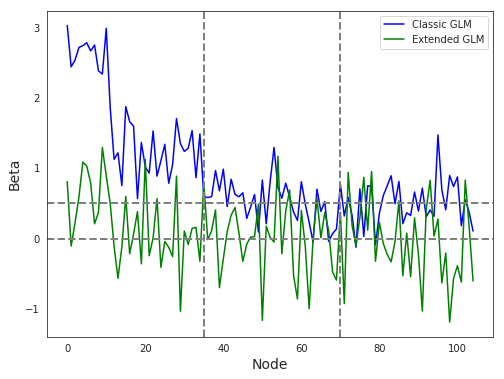

In [29]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(task_betas['ucr_task'], color = "blue", label = "Classic GLM")
plt.plot(task_betas['ext_task'], color = "green", label = "Extended GLM")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='gray', ls = "--")
plt.axhline(y=0,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Current node betas == 1?

Close but systematically slightly overestimated

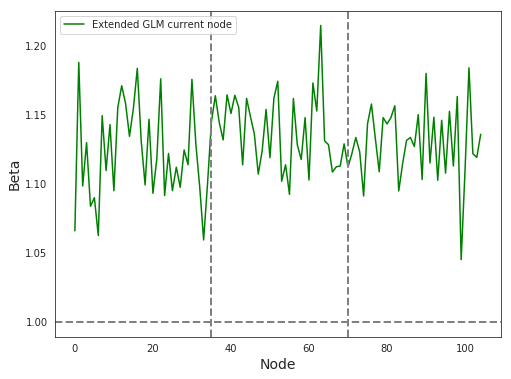

In [30]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(ext_cur_node, color = "green",label = "Extended GLM current node")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")


#### Other node betas recapitulate connectivity matrix?

In the model above $W_{ij}$ appears twice. This gives us two sets of parameters to compare to the weight matrix. 

The first is formed from the coefficients of $\phi\big(\hat{I}_j(t+1)\big)$. This will be the main matrix to compare to the true weight matrix and will be referred to as 'Estimated' below.

The second consists of the coefficients of $\phi\big(\phi\big(\hat{I}_j(t)\big)\big)$. This is one of the three regressors for which we distributed the transformation $\phi$ even though it does not have the distributive property. Based on the simulation above we expect coefficients for this regressor to be underestimated.

In [31]:
ext_weight_matrix_copy = copy.copy(ext_weight_matrix)
ext_phi_weight_matrix_copy = copy.copy(ext_phi_weight_matrix)
nregions = y.shape[0]
weight_matrix_betas = np.zeros((nregions,nregions))
phi_weight_matrix_betas = np.zeros((nregions,nregions))
for i in range(nregions):
    weight_matrix_betas[i] = np.insert(ext_weight_matrix_copy[i],i,0)
    phi_weight_matrix_betas[i] = np.insert(ext_phi_weight_matrix_copy[i],i,0)

Are the estimates good enough?  

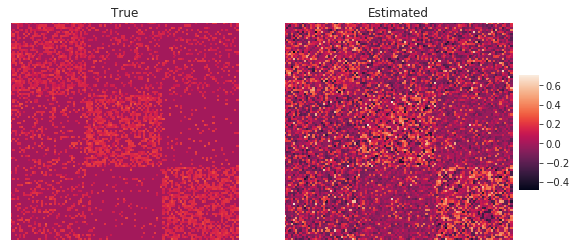

In [32]:
plt.rcParams["figure.figsize"][0] = 9
plt.rcParams["figure.figsize"][1] = 4
fig, axn = plt.subplots(1, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ms = OrderedDict([('W', W) ,
                  ('weight_matrix_betas', weight_matrix_betas)
                  ])
ax_titles = ['True','Estimated']

for i, ax in enumerate(axn.flat):
    df = ms[list(ms.keys())[i]]
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=np.amin(weight_matrix_betas), 
                vmax=np.amax(weight_matrix_betas),
                xticklabels=False, yticklabels=False,
                cbar_ax=None if i else cbar_ax)
    ax.set_title('%s'%(ax_titles[i]))
    ax.set_ylabel('')    
    ax.set_xlabel('')

Is there structure in the residuals between the true weight matrix and the estimated ones?

Text(0.5, 1.0, 'True - Estimated')

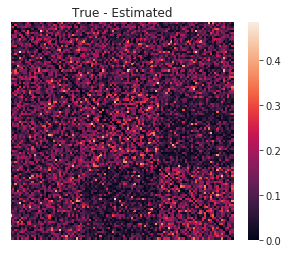

In [33]:
plt.rcParams["figure.figsize"][0] = 5
plt.rcParams["figure.figsize"][1] = 4
sns.heatmap(abs(W-weight_matrix_betas), xticklabels=False, yticklabels=False)
plt.title("True - Estimated")

Statistically checking if the estimated weights are different:  

Flatten the weight matrices (or the difference matrix) and check if the distribution of the weights differ from each other (or if the difference matrix distribution differs from 0)

The distributions have different means though note that the estimated values contain <0 as well because they are not bounded.

In [34]:
t, p = stats.ttest_ind(W.flatten(), weight_matrix_betas.flatten())
print('Mean of true weights = %s'%(str(round(W.flatten().mean(), 3))))
print('Mean of estimated weights = %s'%(str(round(weight_matrix_betas.flatten().mean(), 3))))
print('T statistic = %s'%(str(round(t,3))))
print('P value = %s'%(str(round(p,3))))

Mean of true weights = 0.054
Mean of estimated weights = 0.031
T statistic = 13.014
P value = 0.0


This isn't a very sensitive way though and ignores any spatial/network-related differences in estimation success.  
E.g. is the model worse in estimated the higher connections within local networks or worse in estimating the low correlations between local networks  

In [35]:
print('WITHIN network')

for i in range(3):
    print('Network %s'%(str(i+1)))
    print('Mean of true weights: %s'%(str(round(W[i*nodespercommunity:(i+1)*nodespercommunity, i*nodespercommunity:(i+1)*nodespercommunity].flatten().mean(), 3))))
    print('Mean of estimated weights: %s'%str(round(weight_matrix_betas[i*nodespercommunity:(i+1)*nodespercommunity, i*nodespercommunity:(i+1)*nodespercommunity].flatten().mean(), 3)))

WITHIN network
Network 1
Mean of true weights: 0.092
Mean of estimated weights: 0.076
Network 2
Mean of true weights: 0.103
Mean of estimated weights: 0.081
Network 3
Mean of true weights: 0.101
Mean of estimated weights: 0.081


To-do to improve the estimates:

- Setting constraints on the parameters to avoid negative weights? See last solution [here](https://stackoverflow.com/questions/52589230/python-simple-linear-regression-with-constraint)